# PixelRNN

Partially inspired by https://github.com/heechan95/PixelRNN-pytorch/blob/master/PixelRNN%20pytorch.ipynb

In [1]:
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as T

In [2]:
# parameters from the paper
batch_size = 16
num_layers = 7
hidden_dim = 16

# other parameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
lr = 0.001
num_epochs = 10

The architecture is designed for MNIST only and for static inputs.

In [3]:
# architecture
# 1. 7 x 7 with conv mask A
# 2. Row LSTM with residual blocks
#    a. i-s: 3x1 mask with conv mask B
#    b. s-s: 3x1 no mask
# 3. ReLU + 1x1 conv layer with mask B (2 layers)
# 4. 256 Ways softmax

In [4]:
# Type A masked Conv2d 
class MaskedConv2d(nn.Module):
    def __init__(self, in_channels=1, 
                 out_channels=hidden_dim,
                 kernel_size=7,
                 padding=3):
        super().__init__()
        self.conv = nn.Conv2d(in_channels=in_channels,
                             out_channels=out_channels,
                             kernel_size=kernel_size,
                             padding=padding)
        
        mask_idxs = torch.arange(0, kernel_size**2).view(kernel_size, kernel_size)
        mask = (mask_idxs < padding * kernel_size + padding).float().to(device)
        self.register_buffer('mask', mask)
    
    def forward(self, x):
        # apply mask, see below link for more info
        # https://discuss.pytorch.org/t/applying-custom-mask-on-kernel-for-cnn/87099
        
        with torch.no_grad():
            self.conv.weight = nn.Parameter(self.conv.weight * self.mask)
        return self.conv(x)

In [5]:
test2dLayer = MaskedConv2d().to(device)
testdata = torch.randn(1, 1, 28, 28, device=device)
test2dLayer(testdata).shape

torch.Size([1, 16, 28, 28])

In [6]:
# Type B masked Conv1d
class MaskedConv1d(nn.Module):
    def __init__(self, 
                 in_channels=hidden_dim,
                 out_channels=hidden_dim,
                 kernel_size=3,
                 padding=1):
        super().__init__()
        self.conv = nn.Conv1d(in_channels=in_channels,
                              out_channels=out_channels,
                              kernel_size=kernel_size,
                              padding=padding)
        
        mask = torch.ones(kernel_size, device=device, dtype=torch.float32)
        mask[2] = 0
        self.register_buffer('mask', mask)
        
    def forward(self, x):
        with torch.no_grad():
            self.conv.weight = nn.Parameter(self.conv.weight * self.mask)
        return self.conv(x)

In [7]:
test1dLayer = MaskedConv1d().to(device)
# 16 -> hidden size (number of feature maps), 28 -> width
# the layer processes one row at a time
testdata = torch.randn(1, 16, 28, device=device)
test1dLayer(testdata).shape

torch.Size([1, 16, 28])

The LSTM cell receives one cell at a time.

In [8]:
class RowLSTMCell(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.conv_i_s = MaskedConv1d(in_channels=hidden_dim, 
                                out_channels=4 * hidden_dim,
                                kernel_size=3,
                                padding=1)
        
        self.conv_s_s = nn.Conv1d(in_channels=hidden_dim, 
                                  out_channels=4 * hidden_dim,
                                  kernel_size=3,
                                  padding=1)

    def forward(self, x, h_prev, c_prev):
        i_s = self.conv_i_s(x)
        s_s = self.conv_s_s(h_prev)
        
        o, f, i, g = torch.split(i_s + s_s, hidden_dim, 1)
        o = torch.sigmoid(o)
        f = torch.sigmoid(f)
        i = torch.sigmoid(i)
        g = torch.tanh(g)
        
        c = f * c_prev + i * g
        h = o * torch.tanh(c)
        return h, c

In [9]:
# test Cell
row = torch.randn(1, 16, 28, device=device)
prev_h = torch.randn(1, 16, 28, device=device)
prev_c = torch.randn(1, 16, 28, device=device)

cell = RowLSTMCell().to(device)
h, c = cell(row, prev_h, prev_c)
print(h.shape, c.shape)

torch.Size([1, 16, 28]) torch.Size([1, 16, 28])


In [10]:
class RowLSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.cell = RowLSTMCell()

    
    def forward(self, x):
        _, _, num_rows, _ = x.shape
        h_prev = torch.zeros(x.shape[0], hidden_dim, 28, device=device)
        c_prev = torch.zeros(x.shape[0], hidden_dim, 28, device=device)

        rows = []
        for row_idx in range(num_rows):
            image_row = x[:, :, row_idx, :]
            h_prev, c_prev = self.cell(image_row, h_prev, c_prev)
            rows.append(h_prev.unsqueeze(dim=2))
        return torch.cat(rows, dim=2)

In [11]:
# test row lstm
image = torch.randn(batch_size, 16, 28, 28, device=device)
row_lstm = RowLSTM().to(device)
row_lstm(image).shape

torch.Size([16, 16, 28, 28])

In [12]:
class PixelRNN(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
                MaskedConv2d(), 
                RowLSTM(),
                nn.ReLU(),
                nn.Conv2d(hidden_dim, hidden_dim*2, kernel_size=1),
                nn.ReLU(),
                nn.Conv2d(hidden_dim*2, 1, kernel_size=1)
        )
    
    def forward(self, x):
        return self.layers(x)

In [13]:
test_images = torch.randn(batch_size, 1, 28, 28, device=device)
model = PixelRNN().to(device)
model(test_images).shape

torch.Size([16, 1, 28, 28])

In [14]:
train_dataset = torchvision.datasets.MNIST(root='../datasets/', 
                                           train=True, 
                                           transform=T.ToTensor(), 
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='../datasets/', 
                                           train=False, 
                                           transform=T.ToTensor(), 
                                           download=False)

In [15]:
train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=2)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, drop_last=False, num_workers=2)

In [16]:
model = PixelRNN().to(device)
# mse would most likely also work
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters())

In [17]:
def train():
    for epoch in range(1, num_epochs+1):
        train_loss = []
        for features, _ in train_dataloader:
            features = features.to(device)
            logits = model(features)
            loss = criterion(logits, features)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss.append(loss.cpu().item())
        
        print(f'Epoch: {epoch}/{num_epochs}, Loss: {sum(train_loss)/len(train_loss)}')

In [18]:
train()

Epoch: 1/10, Loss: 0.24843453721602757
Epoch: 2/10, Loss: 0.14908142183621725
Epoch: 3/10, Loss: 0.12582927854855855
Epoch: 4/10, Loss: 0.11728720834453901
Epoch: 5/10, Loss: 0.112956779140234
Epoch: 6/10, Loss: 0.10964896466930707
Epoch: 7/10, Loss: 0.10739512793223063
Epoch: 8/10, Loss: 0.10597590109507243
Epoch: 9/10, Loss: 0.10491630700826644
Epoch: 10/10, Loss: 0.10391491771936416


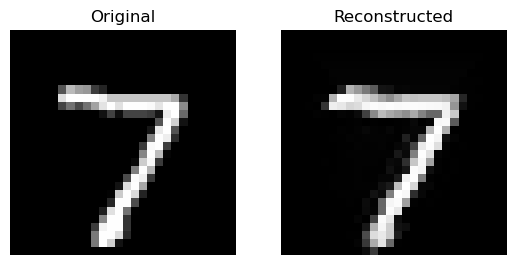

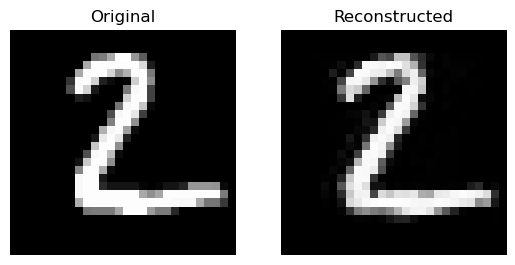

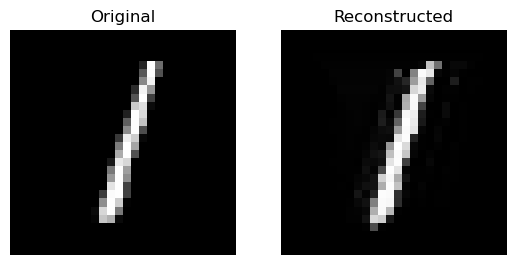

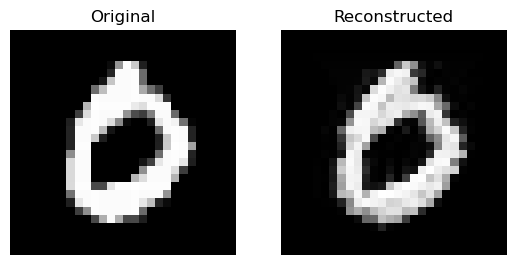

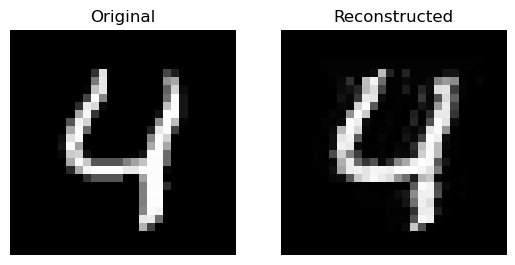

In [19]:
# test the reconstruction by comparing theinference_modeginal with the reconstructed images
with torch.inference_mode():
    for idx in range(5):
        image, _ = test_dataset[idx]
        image = image.unsqueeze(0)
        generated_image = model(image.to(device))
        generated_image = torch.sigmoid(generated_image)
        generated_image = generated_image.squeeze()

        plt.subplot(1, 2, 1)
        plt.imshow(image.squeeze(), cmap="gray")
        plt.title("Original")
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.imshow(generated_image.cpu(), cmap="gray")
        plt.title("Reconstructed")
        plt.axis("off")
        plt.show()

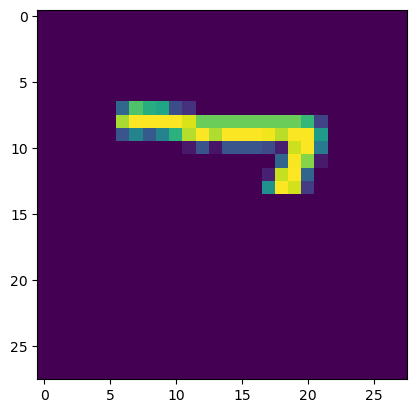

In [41]:
image, _ = test_dataset[0]
image = image.squeeze()
for row_idx, row in enumerate(image):
    for col_idx, _ in enumerate(image):
        if row_idx >= 14:
            image[row_idx][col_idx] = 0
plt.imshow(image.squeeze())

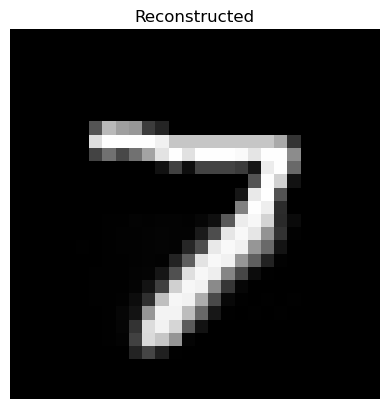

In [42]:
image, _ = test_dataset[0]
image = image.squeeze()
for row_idx, row in enumerate(image):
    for col_idx, _ in enumerate(image):
        if row_idx >= 14:
            image[row_idx][col_idx] = 0

image = image.unsqueeze(0).unsqueeze(0).to(device) 
with torch.inference_mode():
    for row_idx in range(28):
        for col_idx in range(28):
            generated_image = model(image)
            generated_image = torch.sigmoid(generated_image)
            generated_image = generated_image.squeeze()
            if row_idx >=14:
                image[0][0][row_idx][col_idx] = generated_image[row_idx][col_idx]
            
plt.imshow(image.cpu().squeeze(), cmap="gray")
plt.title("Reconstructed")
plt.axis("off")
plt.show()
